In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 12})

from scipy import signal 
from scipy import stats
import itertools
import seaborn as sns
import statsmodels.api as sm

import os
import random
import datetime

In [2]:
import pickle
import json
json_open = open('../../dj_local_conf.json', 'r') 
config = json.load(json_open)

import datajoint as dj
dj.config['database.host'] = config["database.host"]
dj.config['database.user'] = config ["database.user"]
dj.config['database.password'] = config["database.password"]
dj.conn().connect()

from pipeline import lab, get_schema_name, experiment, foraging_model, ephys, foraging_analysis, histology, ccf
from pipeline.plot import unit_psth
from pipeline.plot.foraging_model_plot import plot_session_model_comparison, plot_session_fitted_choice
from pipeline import psth_foraging
from pipeline import util
from pipeline.model import bandit_model

from UtilFunctions_KH import _get_independent_variableKH, align_phys_to_behav_trials

/home/map/.local/lib/python3.6/site-packages/pymysql/_auth.py:8: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography and will be removed in a future release.
  from cryptography.hazmat.backends import default_backend


Connecting pochen@datajoint.mesoscale-activity-map.org:3306


In [27]:
'''
DATA_ROOT_DIR = '../../data/nm_data'
ANA_DIR = 'FB26_220810/'
ana_dir_path = os.path.join(DATA_ROOT_DIR, ANA_DIR)

with open(os.path.join(ana_dir_path, 'data_frame.pkl'), 'rb') as fh:
    df = pickle.load(fh)
'''

'''
# generate session_lut
subject_id = 627713

if ANA_DIR not in session_lut.keys():
    # get session id from session date
    full_date = ANA_DIR[:-1].split('_')[1]
    year, month, date = int('20'+full_date[:2]), int(full_date[2:4]), int(full_date[4:])
    session_date = datetime.date(year, month, date)

    df_session = pd.DataFrame(experiment.Session & 'subject_id=627713')
    session = df_session[df_session['session_date']==session_date].iloc[0]['session']
    print(f' get session for ANA_DIR: {session}')
else:
    session = session_lut[ANA_DIR]
'''

In [16]:
# get nm aligned data
def get_aligned_traces(ana_dir, session_lut, sess_key, model_id, 
                       DATA_ROOT_DIR = '../../data/nm_data', plot_raw=False, plot_aligned=False):
    trial_align = True

    # load df
    ana_dir_path = os.path.join(DATA_ROOT_DIR, ana_dir)
    with open(os.path.join(ana_dir_path, 'data_frame.pkl'), 'rb') as fh:
        df = pickle.load(fh)

    # load lat variables
    model_id = 10
    mouse = 'KH_' + ana_dir[:-1].split('_')[0]
    subject_id = (lab.WaterRestriction & f'water_restriction_number="{mouse}"').fetch('subject_id')[0]
    session = session_lut[ana_dir]
    sess_key = {
    'subject_id': subject_id,
    'session': session}
    LatVars = _get_independent_variableKH(sess_key, model_id=model_id, var_name=None)

    if plot_raw:
        # plot raw
        plt.figure(figsize=(10, 8), dpi=150)
        plt.subplot(6,1,2)
        plt.plot(LatVars['left_action_value'],color='blue')
        plt.plot(LatVars['right_action_value'],color='orange')
        plt.title('L(blue) / R(orange) action values')

        plt.subplot(6,1,3)
        plt.plot(LatVars['relative_action_value_lr'],color='black')
        plt.title('relative_action_value: L - R')

        plt.subplot(6,1,4)
        plt.plot(LatVars['total_action_value'],color='black')
        plt.title('total_action_value')

        plt.subplot(6,1,5)
        plt.plot(LatVars['rpe'],color='black')
        plt.title('RewardPredictionError')

        ax = plt.subplot(6,1,1)
        plot_session_fitted_choice(sess_key, specified_model_ids=model_id, 
                                ax=ax, remove_ignored=False)
        # plt.tight_layout()

    # Trial Align
    if trial_align:
        ophys_barcode = df['Barcode'].tolist() # This is so far manually imported from the photometry standalone
        behav_trialN, behav_barcode = (experiment.TrialNote & sess_key & 'trial_note_type = "bitcode"').fetch('trial', 'trial_note', order_by='trial')

        trial_aligned = align_phys_to_behav_trials(ophys_barcode, list(behav_barcode), list(behav_trialN))

        mp = trial_aligned['phys_to_behav_mapping']

        df_aligned = df.iloc[0:0]
        LatVars_aligned = LatVars.iloc[0:0]

        for ii in range(len(mp)):
            ophys_trial_this = mp[ii][0]-1  # note ophys is pd-row index-based
            behave_trial_this= mp[ii][1]
            
            if any(LatVars['trial'] == behave_trial_this):      # when false, ignored trial (no latent variables)
                df_aligned = df_aligned.append(df.iloc[ophys_trial_this,:])
                LatVars_aligned = LatVars_aligned.append(LatVars[LatVars['trial'] == behave_trial_this])

        print(f' aligned nm traces: {df_aligned.shape}')
        print(f' aligned lat vars: {LatVars_aligned.shape}')

    if plot_aligned:

        # plot aligned
        plt.figure(figsize=(10,8), dpi=150)
        plt.subplot(6,1,2)
        plt.plot(LatVars_aligned['left_action_value'], color='blue')
        plt.plot(LatVars_aligned['right_action_value'], color='orange')
        plt.title('L(blue) / R(orange) action values')

        plt.subplot(6,1,3)
        plt.plot(LatVars_aligned['relative_action_value_lr'],color='black')
        plt.title('relative_action_value: L - R')

        plt.subplot(6,1,4)
        plt.plot(LatVars_aligned['total_action_value'],color='black')
        plt.title('total_action_value')

        plt.subplot(6,1,5)
        plt.plot(LatVars_aligned['rpe'],color='black')
        plt.title('RewardPredictionError')


        temp = df_aligned['Resp_l']
        Y_this=[]
        for item in temp:
            Y_this = np.append(Y_this, item[3])

        plt.subplot(6,1,6)
        plt.plot(Y_this, color='maroon')
        plt.title('FP_Late_response')

        ax = plt.subplot(6,1,1)
        plot_session_fitted_choice(sess_key, specified_model_ids=model_id, 
                                ax=ax, remove_ignored=False)

    return df_aligned, LatVars_aligned

In [ ]:
# fetch and organize data

signal_types = ['G1', 'R1', 'G2', 'R2']

nm_trace_columns = ['session', 'resp_type', 'trace']  # resp_type in resp_types
nm_traces_dict = {signal_type: pd.DataFrame(columns=nm_trace_columns) for signal_type in signal_types}
resp_types = ['Resp_e', 'Resp_l', 'Resp_t', 'Resp_base']

q_latent_columns = ['session', 'q_type', 'q_time_series']
q_latents = {signal_type: pd.DataFrame(columns=q_latent_columns) for signal_type in signal_types}
q_types = ['Q_left', 'Q_right', 'rpe']


session_lut = {
    'FB26_220715/': 17,
    #'FB26_220719/': 19, n=0
    #'FB26_220803/': 25, n=1
    'FB26_220726/': 23,
    'FB26_220805/': 27,
    'FB26_220808/': 28,
    'FB26_220810/': 29}

model_id = 10


for i, signal_type in enumerate(signal_types):
    print(f'{i} {signal_type}')
    df_nm_traces = nm_traces_dict[signal_type]
    df_q_latents = q_latents[signal_type]

    for ana_dir in session_lut.keys():
        print(f'{ana_dir}')

        mouse = 'KH_' + ana_dir[:-1].split('_')[0]
        subject_id = (lab.WaterRestriction & f'water_restriction_number="{mouse}"').fetch('subject_id')[0]

        session = session_lut[ana_dir]
        sess_key = {
            'subject_id': subject_id,
            'session': session}
        df_aligned, LatVars_aligned = get_aligned_traces(ana_dir, session_lut, sess_key, model_id)

        for resp_type in resp_types:
            resp = np.vstack(df_aligned[resp_type].values).astype(np.float)[:, i]
            print(f' {resp_type} resp: {resp.shape}')
            df_nm_traces.loc[len(df_nm_traces.index)] = [session, resp_type, resp]
        
        for q_type in q_types:
            if q_type == 'Q_left':
                q_time_series = LatVars_aligned['left_action_value'].values
            elif q_type == 'Q_right':
                q_time_series = LatVars_aligned['right_action_value'].values
            elif q_type == 'rpe':
                q_time_series = LatVars_aligned['rpe'].values
            else:
                raise ValueError(f'wrong q_type: {q_type}')
            print(f' {q_type} q: {q_time_series.shape}')
            df_q_latents.loc[len(df_q_latents.index)] = [session, q_type, q_time_series]

In [37]:
# save the data df if not existed
with open('./ophys_nm_traces.pickle', 'wb') as handle:
    pickle.dump(nm_traces_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('./ophys_q_latents.pickle', 'wb') as handle:
    pickle.dump(q_latents, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
# load data
with open('./ophys_nm_traces.pickle', 'rb') as handle:
    nm_traces_dict = pickle.load(handle)

with open('./ophys_q_latents.pickle', 'rb') as handle:
    q_latents = pickle.load(handle)

### Standard analysis

In [ ]:
# std fit, single neuron encoding
signal_types_to_fit = ['G1', 'R1', 'G2', 'R2']
resp_types = ['Resp_e', 'Resp_l', 'Resp_t', 'Resp_base']
q_types = ['Q_left', 'Q_right', 'rpe']

std_encode_columns = ['src_session', 'resp_type', 'fit_session', 
                      'tvalues_Q_left', 'tvalues_Q_right', 'tvalues_rpe']
df_std_encode_dict = {signal_type: pd.DataFrame(columns=std_encode_columns) 
                      for signal_type in signal_types_to_fit}


# fit resps from signals
for signal_type in signal_types_to_fit:
    print(f'signal type {signal_type}')
    nm_traces_type = nm_traces_dict[signal_type]

    df_Qs = q_latents[signal_type]
    
    df_std_fit = df_std_encode_dict[signal_type]


    for session in np.unique(df_Qs['session'].values):
        nm_traces_type_session = nm_traces_type[nm_traces_type['session']==session]
        
        df_Qs_session = df_Qs[df_Qs['session']==session]
        X = np.empty((len(df_Qs_session.iloc[0]['q_time_series']),
                      len(q_types)))
        for j, q_type in enumerate(q_types):
            X[:, j] = df_Qs_session[df_Qs_session['q_type']==q_type].iloc[0]['q_time_series']
        X = sm.add_constant(X)
        print(f' session {session}: {X.shape}')

        for resp_type in resp_types:
            fr = nm_traces_type_session[nm_traces_type_session['resp_type']==resp_type].iloc[0]['trace']
            
            model = sm.OLS(fr, X)
            results = model.fit()
            #print(f' fit tvalue: {results.tvalues}')
            df_std_fit.loc[len(df_std_fit.index)] = [session, resp_type, session, 
                results.tvalues[1], results.tvalues[2], results.tvalues[3]]

In [ ]:
# plot std fit, single neuron encoding
signal_types_to_fit = ['G1', 'R1', 'G2', 'R2']
resp_types = ['Resp_e', 'Resp_l', 'Resp_t', 'Resp_base']
q_types = ['Q_left', 'Q_right', 'rpe']

percentiles_2_compute = [2.5, 97.5]

# Q_left/right scatter plot
tvalue_lim = (-10, 10)
tvalue_sig_thresh = (-2, 2)
dot_size = 8
# hist plot
colors = {
    'Q_left': 'r',
    'Q_right': 'b',
    'sigma_Q': 'c',
    'delta_Q': 'peru',
    'rpe': 'g'
}
# bar plot
classified_types = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q', 'rpe']
bar_colors = ['r', 'b', 'c', 'peru', 'g']



for signal_type_id, signal_type in enumerate(signal_types_to_fit):
    print(f'{signal_type}')
    df_fit = df_std_encode_dict[signal_type]

    fig, axs = plt.subplots(
                    len(resp_types), 
                    3, # (Q_left/right scatter, rpe hist, num of sig sessions) 
                    figsize=(4*3, 
                             3*len(resp_types)), 
                    dpi=150)
    
    for resp_type_id, resp_type in enumerate(resp_types):
        row_ind = resp_type_id
        df_fit_resp_type = df_fit[df_fit['resp_type']==resp_type]
    
        # Q_left/ right scatter
        col_ind = 0
        # choose tvalue_sig_threshold
        # (-2, 2) for naive case
        tvalue_sig_threshold = {'Q_left': tvalue_sig_thresh, 
                                'Q_right': tvalue_sig_thresh} 
        # dynamic for adv analysis
        # tvalue_sig_threshold = {'Q_left': tvalues_percentile['Q_left'], 'Q_right': tvalues_percentile['Q_right']} 
        df_fit_Q_left_sig = df_fit_resp_type[
                                ((df_fit_resp_type['tvalues_Q_left']>=tvalue_sig_threshold['Q_left'][1]) | 
                                 (df_fit_resp_type['tvalues_Q_left']<=tvalue_sig_threshold['Q_left'][0])) & 
                                (df_fit_resp_type['tvalues_Q_right']<tvalue_sig_threshold['Q_right'][1]) & 
                                (df_fit_resp_type['tvalues_Q_right']>tvalue_sig_threshold['Q_right'][0])]
        axs[row_ind, col_ind].scatter(
                                df_fit_Q_left_sig['tvalues_Q_left'].values, 
                                df_fit_Q_left_sig['tvalues_Q_right'].values, 
                                color='r', s=dot_size, label='Q_left')
        df_fit_Q_right_sig = df_fit_resp_type[
                                ((df_fit_resp_type['tvalues_Q_right']>=tvalue_sig_threshold['Q_right'][1]) | 
                                 (df_fit_resp_type['tvalues_Q_right']<=tvalue_sig_threshold['Q_right'][0])) & 
                                (df_fit_resp_type['tvalues_Q_left']<tvalue_sig_threshold['Q_left'][1]) & 
                                (df_fit_resp_type['tvalues_Q_left']>tvalue_sig_threshold['Q_left'][0])]
        axs[row_ind, col_ind].scatter(
                                df_fit_Q_right_sig['tvalues_Q_left'].values, 
                                df_fit_Q_right_sig['tvalues_Q_right'].values, 
                                color='b', s=dot_size, label='Q_right')
        df_fit_sigma_Q_sig = df_fit_resp_type[
                                ((df_fit_resp_type['tvalues_Q_left']>=tvalue_sig_threshold['Q_left'][1]) & 
                                 (df_fit_resp_type['tvalues_Q_right']>=tvalue_sig_threshold['Q_right'][1])) | 
                                ((df_fit_resp_type['tvalues_Q_left']<=tvalue_sig_threshold['Q_left'][0]) & 
                                 (df_fit_resp_type['tvalues_Q_right']<=tvalue_sig_threshold['Q_right'][0]))]
        axs[row_ind, col_ind].scatter(
                                df_fit_sigma_Q_sig['tvalues_Q_left'].values, 
                                df_fit_sigma_Q_sig['tvalues_Q_right'].values, 
                                color='c', s=dot_size, label='sigma_Q')
        df_fit_delta_Q_sig = df_fit_resp_type[
                                ((df_fit_resp_type['tvalues_Q_left']>=tvalue_sig_threshold['Q_left'][1]) & 
                                 (df_fit_resp_type['tvalues_Q_right']<=tvalue_sig_threshold['Q_right'][0])) | 
                                ((df_fit_resp_type['tvalues_Q_left']<=tvalue_sig_threshold['Q_left'][0]) & 
                                 (df_fit_resp_type['tvalues_Q_right']>=tvalue_sig_threshold['Q_right'][1]))]
        axs[row_ind, col_ind].scatter(
                                df_fit_delta_Q_sig['tvalues_Q_left'].values, 
                                df_fit_delta_Q_sig['tvalues_Q_right'].values, 
                                color='peru', s=dot_size, label='delta_Q')
        df_fit_null = df_fit_resp_type[
                            (df_fit_resp_type['tvalues_Q_left']<tvalue_sig_threshold['Q_left'][1]) & 
                            (df_fit_resp_type['tvalues_Q_left']>tvalue_sig_threshold['Q_left'][0]) & 
                            (df_fit_resp_type['tvalues_Q_right']<tvalue_sig_threshold['Q_right'][1]) & 
                            (df_fit_resp_type['tvalues_Q_right']>tvalue_sig_threshold['Q_right'][0])]
        axs[row_ind, col_ind].scatter(
                                df_fit_null['tvalues_Q_left'].values, 
                                df_fit_null['tvalues_Q_right'].values, 
                                color='k', s=dot_size)
        sum_classified_sessions = len(df_fit_Q_left_sig)+len(df_fit_Q_right_sig)+ \
                                    len(df_fit_sigma_Q_sig)+len(df_fit_delta_Q_sig)+ \
                                    len(df_fit_null)
        if len(df_fit_resp_type) != sum_classified_sessions:
            raise ValueError(f'sum of dots doesnt match: {len(df_fit_resp_type)} {sum_classified_sessions}')

        axs[row_ind, col_ind].hlines(tvalue_sig_thresh, tvalue_lim[0], tvalue_lim[1], color='k', linestyle='--')
        axs[row_ind, col_ind].vlines(tvalue_sig_thresh, tvalue_lim[0], tvalue_lim[1], color='k', linestyle='--')
        axs[row_ind, col_ind].set_title(f'Q encoding analysis: {signal_type} {resp_type}')
        axs[row_ind, col_ind].set_xlim(tvalue_lim[0], tvalue_lim[1])
        axs[row_ind, col_ind].set_ylim(tvalue_lim[0], tvalue_lim[1])
        axs[row_ind, col_ind].set_xlabel('t values for Q_left')
        axs[row_ind, col_ind].set_ylabel('t values for Q_right')
        # axs[row_ind, col_ind].legend()


        # histogram of rpe tvalues
        col_ind = 1
            
        rpe_tvalues = df_fit_resp_type['tvalues_rpe'].values
        hist_q, _, _ = axs[row_ind, col_ind].hist(rpe_tvalues, 
                                                bins=24, range=tvalue_lim, histtype='stepfilled', 
                                                color=colors['rpe'], label='rpe', alpha=0.5)
        axs[row_ind, col_ind].vlines(tvalue_sig_thresh, 0, np.max(hist_q)+2, 
                                    color='k', linestyle='--', alpha=0.5)

        axs[row_ind, col_ind].set_title(f'Hist of rpe t values: {signal_type} {resp_type}')
        axs[row_ind, col_ind].set_xlabel('t value')
        axs[row_ind, col_ind].set_ylabel('count')
        axs[row_ind, col_ind].legend()

        n_sessions_rpe_sig = np.sum(((rpe_tvalues >= 2) |
                                     (rpe_tvalues <= -2)))

    
        # bar plot for significant neurons
        col_ind = 2
        n_sessions_fit = len(df_fit_resp_type)
        print(f'{signal_type} {resp_type} total dots: {n_sessions_fit}')
        print(f' classified Q_left: {len(df_fit_Q_left_sig)}')
        print(f' classified Q_right: {len(df_fit_Q_right_sig)}')
        print(f' classified sigma_Q: {len(df_fit_sigma_Q_sig)}')
        print(f' classified delta_Q: {len(df_fit_delta_Q_sig)}')
        print(f' classified rpe: {n_sessions_rpe_sig}')
        classified_ratios = [
            len(df_fit_Q_left_sig)/ float(n_sessions_fit),
            len(df_fit_Q_right_sig)/ float(n_sessions_fit),
            len(df_fit_sigma_Q_sig)/ float(n_sessions_fit),
            len(df_fit_delta_Q_sig)/ float(n_sessions_fit),
            n_sessions_rpe_sig/ float(n_sessions_fit)]
        axs[row_ind, col_ind].bar(classified_types, classified_ratios, color=bar_colors)
        x_lim = axs[row_ind, col_ind].get_xlim()
        axs[row_ind, col_ind].hlines(0.05, x_lim[0], x_lim[1], color='k', linestyle='--')
        axs[row_ind, col_ind].set_title(f'ratio of classification: {signal_type} {resp_type}')
        axs[row_ind, col_ind].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

### multi-session PERMUTATION analysis

In [17]:
# msp fit, single neuron encoding
# compute the test statistic: sum of residuals from regression models
# in all possible permutations


signal_types_to_fit = ['G1', 'R1', 'G2', 'R2']
resp_types = ['Resp_e', 'Resp_l', 'Resp_t', 'Resp_base']
q_types = ['Q_left', 'Q_right', 'rpe']


msp_encode_columns = ['gen_session_perm', 'resp_type', 'fit_session_perm', 
                      'residuals', 'mse_total', 'tvalues_Q_left', 'tvalues_Q_right', 'tvalues_rpe']
df_msp_encode_dict = {signal_type: pd.DataFrame(columns=msp_encode_columns) 
                     for signal_type in signal_types_to_fit}


# fit resps from signals
for signal_type in signal_types_to_fit:
    print(f'signal type {signal_type}')
    nm_traces_type = nm_traces_dict[signal_type]

    df_Qs = q_latents[signal_type]
    sessions = np.unique(df_Qs['session'].values)
    # calculate minimal session length
    sess_min_len = 100000
    for sess in sessions:
        df_Qs_sess = df_Qs[df_Qs['session']==sess]
        sess_len = len(df_Qs_sess.iloc[0]['q_time_series'])
        sess_min_len = min(sess_min_len, sess_len)
    print(f' min session length: {sess_min_len}')
    
    df_msp_fit = df_msp_encode_dict[signal_type]


    for j, p in enumerate(itertools.permutations(range(len(sessions)))):
        print(f'  permutation {j}: {p}')

        for resp_type in resp_types:
            gen_session_perm = []
            fit_session_perm = []
            residuals = []
            mse_total = []
            tvalues_Q_left, tvalues_Q_right, tvalues_rpe = [], [], []

            nm_traces_type_resp = nm_traces_type[nm_traces_type['resp_type']==resp_type]

            for i, session in enumerate(sessions):
                gen_session = sessions[i]
                fit_session = sessions[p[i]]
                gen_session_perm.append(gen_session)
                fit_session_perm.append(fit_session)
                # print(f'   using gen_session {gen_session} and fit_session {fit_session}')

                # get population activity
                nm_traces_type_resp_session = nm_traces_type_resp[nm_traces_type_resp['session']==gen_session]
                if len(nm_traces_type_resp_session) == 1:
                    fr = nm_traces_type_resp_session.iloc[0]['trace'][:sess_min_len]
                else:
                    raise ValueError(f'Incorrect nm_traces_type_resp_session shape: {len(nm_traces_type_resp_session)}')

                # get Qs
                df_Qs_session = df_Qs[df_Qs['session']==fit_session]
                X = np.empty((sess_min_len,
                              len(q_types)))
                for _j, q_type in enumerate(q_types):
                    df_Qs_session_q_type = df_Qs_session[df_Qs_session['q_type']==q_type]
                    if len(df_Qs_session_q_type) == 1:
                        X[:, _j] = df_Qs_session_q_type.iloc[0]['q_time_series'][:sess_min_len]
                    else:
                        raise ValueError(f'Incorrect nm_traces_type_resp_session shape: {len(df_Qs_session_q_type)}')
                X = sm.add_constant(X)
                # print(f'   session {session}: {X.shape}')

                # fit session
                model = sm.OLS(fr, X)
                results = model.fit()
                residuals.append(results.resid)
                mse_total.append(results.mse_total)
                tvalues_Q_left.append(results.tvalues[1])
                tvalues_Q_right.append(results.tvalues[2])
                tvalues_rpe.append(results.tvalues[3])
            
            residuals = np.array(residuals)
            mse_total = np.array(mse_total)
            tvalues_Q_left = np.array(tvalues_Q_left)
            tvalues_Q_right = np.array(tvalues_Q_right)
            tvalues_rpe = np.array(tvalues_rpe)
            df_msp_fit.loc[len(df_msp_fit.index)] = [gen_session_perm, resp_type, fit_session_perm, 
                                                     residuals, mse_total, tvalues_Q_left, tvalues_Q_right, tvalues_rpe]

signal type G1
 min session length: 412
  permutation 0: (0, 1, 2, 3, 4)
  permutation 1: (0, 1, 2, 4, 3)
  permutation 2: (0, 1, 3, 2, 4)
  permutation 3: (0, 1, 3, 4, 2)
  permutation 4: (0, 1, 4, 2, 3)
  permutation 5: (0, 1, 4, 3, 2)
  permutation 6: (0, 2, 1, 3, 4)
  permutation 7: (0, 2, 1, 4, 3)
  permutation 8: (0, 2, 3, 1, 4)
  permutation 9: (0, 2, 3, 4, 1)
  permutation 10: (0, 2, 4, 1, 3)
  permutation 11: (0, 2, 4, 3, 1)
  permutation 12: (0, 3, 1, 2, 4)
  permutation 13: (0, 3, 1, 4, 2)
  permutation 14: (0, 3, 2, 1, 4)
  permutation 15: (0, 3, 2, 4, 1)
  permutation 16: (0, 3, 4, 1, 2)
  permutation 17: (0, 3, 4, 2, 1)
  permutation 18: (0, 4, 1, 2, 3)
  permutation 19: (0, 4, 1, 3, 2)
  permutation 20: (0, 4, 2, 1, 3)
  permutation 21: (0, 4, 2, 3, 1)
  permutation 22: (0, 4, 3, 1, 2)
  permutation 23: (0, 4, 3, 2, 1)
  permutation 24: (1, 0, 2, 3, 4)
  permutation 25: (1, 0, 2, 4, 3)
  permutation 26: (1, 0, 3, 2, 4)
  permutation 27: (1, 0, 3, 4, 2)
  permutation 28: 

In [18]:
# save the msp_encode df if not existed
with open('./ophys_msp_encode.pickle', 'wb') as handle:
    pickle.dump(df_msp_encode_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
df_msp_encode_dict['G1'].iloc[0]['tvalues_Q_left']

array([-0.8996339 ,  0.34693346,  0.79099567,  4.43591407,  2.57555424])

In [ ]:
# plot ps fit, single neuron encoding
with open('./ophys_ps_encode.pickle', 'rb') as handle:
    df_ps_encode_dict = pickle.load(handle)


signal_types_to_fit = ['G1', 'R1', 'G2', 'R2']
resp_types = ['Resp_e', 'Resp_l', 'Resp_t', 'Resp_base']
q_types = ['Q_left', 'Q_right', 'rpe']

percentiles_2_compute = [2.5, 97.5]


# hist of ps ensemble
tvalue_lim = (-6, 6)
tvalue_sig_thresh = (-2, 2)
# Q_left/right scatter plot
tvalue_percentile_lim = (-5, 105)
dot_size = 10
# hist plot
colors = {
    'Q_left': 'r',
    'Q_right': 'b',
    'sigma_Q': 'c',
    'delta_Q': 'peru',
    'rpe': 'g'
}
# bar plot
classified_types = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q', 'rpe']
bar_colors = ['r', 'b', 'c', 'peru', 'g']


# plot
for signal_type_id, signal_type in enumerate(signal_types_to_fit):
    print(f'{signal_type}')
    df_fit = df_ps_encode_dict[signal_type]

    fig, axs = plt.subplots(
                    len(resp_types), 
                    4, # (example hist, Q_left/right scatter, rpe hist, num of sig sessions) 
                    figsize=(4*4, 
                             3*len(resp_types)), 
                    dpi=150)
    
    for resp_type_id, resp_type in enumerate(resp_types):
        
        row_ind = resp_type_id
        df_fit_resp_type = df_fit[df_fit['resp_type']==resp_type]

        # calculate percentile of t values of self-fitted sessions
        # based on the ensemble of pseudo sessions

        df_fit_t_percentile_agnt_null = pd.DataFrame(columns=['session', 
                                            'Q_left', 'Q_right', 'rpe'])
        
        hist_to_plot_session = np.random.choice(np.unique(df_fit_resp_type['src_session'].values).astype(np.int))

        for session in np.unique(df_fit_resp_type['src_session'].values).astype(np.int):
            df_fit_resp_type_session = df_fit_resp_type[df_fit_resp_type['src_session']==session]
            if len(df_fit_resp_type_session) == 121:
                t_percentile_agnt_null = [session]
                for i, q_type in enumerate(q_types):
                    tvalues_q_type = df_fit_resp_type_session[f'tvalues_{q_type}'].values
                    
                    # get self fitted t value
                    df_self_fitted = df_fit_resp_type_session[df_fit_resp_type_session['src_session']==df_fit_resp_type_session['fit_session']]
                    if len(df_self_fitted) == 1:
                        tvalue_self_q_type = df_self_fitted.iloc[0][f'tvalues_{q_type}']
                    else:
                        raise ValueError(f'incorrect self fitted df len: {len(df_self_fitted)}')

                    t_percentile_agnt_null.append(stats.percentileofscore(tvalues_q_type, tvalue_self_q_type))


                    # histogram of regression tvalues
                    if session == hist_to_plot_session:
                        col_ind = 0
                        tvalues_percentile_q_type = np.percentile(tvalues_q_type, percentiles_2_compute)
                        hist_q_type, _, _ = axs[row_ind, col_ind].hist(tvalues_q_type, bins=24, 
                                                                       histtype='stepfilled', 
                                                                       color=colors[q_type], label=q_type, alpha=0.3)
                        axs[row_ind, col_ind].vlines(tvalue_self_q_type, 0, np.max(hist_q_type)+3, 
                                                     color=colors[q_type])
                        axs[row_ind, col_ind].vlines(tvalues_percentile_q_type, 0, np.max(hist_q_type)+3, 
                                                    color=colors[q_type], linestyle='--', alpha=0.5)
                        axs[row_ind, col_ind].vlines(tvalue_sig_thresh, 0, np.max(hist_q_type)+3, 
                                                    color='k', linestyle='--', alpha=0.3)
                        axs[row_ind, col_ind].set_title(f'Example hist: {signal_type} {resp_type}: sess {session}')
                        axs[row_ind, col_ind].set_xlabel('t value')
                        axs[row_ind, col_ind].set_ylabel('count')
                        axs[row_ind, col_ind].legend()
                df_fit_t_percentile_agnt_null.loc[len(df_fit_t_percentile_agnt_null.index)] = t_percentile_agnt_null
                
            else:
                raise ValueError(f'wrong ps ensemble number: {len(df_fit_resp_type_session)}')


        print(f' df_fit_percentile_against_null: {df_fit_t_percentile_agnt_null.shape}')
        print(f' df_fit_percentile_against_null: {df_fit_t_percentile_agnt_null}')
        # Q_left/ right scatter
        col_ind = 1
        # choose tvalue_sig_threshold
        # (-2, 2) for naive case
        # tvalue_sig_threshold = {'Q_left': tvalue_sig_thresh, 
         #                       'Q_right': tvalue_sig_thresh} 
        # dynamic for adv analysis
        # tvalue_sig_threshold = {'Q_left': tvalues_percentile['Q_left'], 'Q_right': tvalues_percentile['Q_right']} 
        # (2.5, 97.5) for percentile case
        tvalue_sig_threshold = {'Q_left': percentiles_2_compute,
                                'Q_right': percentiles_2_compute} 
        df_fit_Q_left_sig = df_fit_t_percentile_agnt_null[
                                ((df_fit_t_percentile_agnt_null['Q_left']>=tvalue_sig_threshold['Q_left'][1]) | 
                                 (df_fit_t_percentile_agnt_null['Q_left']<=tvalue_sig_threshold['Q_left'][0])) & 
                                (df_fit_t_percentile_agnt_null['Q_right']<tvalue_sig_threshold['Q_right'][1]) & 
                                (df_fit_t_percentile_agnt_null['Q_right']>tvalue_sig_threshold['Q_right'][0])]
        axs[row_ind, col_ind].scatter(
                                df_fit_Q_left_sig['Q_left'].values, 
                                df_fit_Q_left_sig['Q_right'].values, 
                                color='r', s=dot_size, label='Q_left')
        df_fit_Q_right_sig = df_fit_t_percentile_agnt_null[
                                ((df_fit_t_percentile_agnt_null['Q_right']>=tvalue_sig_threshold['Q_right'][1]) | 
                                 (df_fit_t_percentile_agnt_null['Q_right']<=tvalue_sig_threshold['Q_right'][0])) & 
                                (df_fit_t_percentile_agnt_null['Q_left']<tvalue_sig_threshold['Q_left'][1]) & 
                                (df_fit_t_percentile_agnt_null['Q_left']>tvalue_sig_threshold['Q_left'][0])]
        axs[row_ind, col_ind].scatter(
                                df_fit_Q_right_sig['Q_left'].values, 
                                df_fit_Q_right_sig['Q_right'].values, 
                                color='b', s=dot_size, label='Q_right')
        df_fit_sigma_Q_sig = df_fit_t_percentile_agnt_null[
                                ((df_fit_t_percentile_agnt_null['Q_left']>=tvalue_sig_threshold['Q_left'][1]) & 
                                 (df_fit_t_percentile_agnt_null['Q_right']>=tvalue_sig_threshold['Q_right'][1])) | 
                                ((df_fit_t_percentile_agnt_null['Q_left']<=tvalue_sig_threshold['Q_left'][0]) & 
                                 (df_fit_t_percentile_agnt_null['Q_right']<=tvalue_sig_threshold['Q_right'][0]))]
        axs[row_ind, col_ind].scatter(
                                df_fit_sigma_Q_sig['Q_left'].values, 
                                df_fit_sigma_Q_sig['Q_right'].values, 
                                color='c', s=dot_size, label='sigma_Q')
        df_fit_delta_Q_sig = df_fit_t_percentile_agnt_null[
                                ((df_fit_t_percentile_agnt_null['Q_left']>=tvalue_sig_threshold['Q_left'][1]) & 
                                 (df_fit_t_percentile_agnt_null['Q_right']<=tvalue_sig_threshold['Q_right'][0])) | 
                                ((df_fit_t_percentile_agnt_null['Q_left']<=tvalue_sig_threshold['Q_left'][0]) & 
                                 (df_fit_t_percentile_agnt_null['Q_right']>=tvalue_sig_threshold['Q_right'][1]))]
        axs[row_ind, col_ind].scatter(
                                df_fit_delta_Q_sig['Q_left'].values, 
                                df_fit_delta_Q_sig['Q_right'].values, 
                                color='peru', s=dot_size, label='delta_Q')
        df_fit_null = df_fit_t_percentile_agnt_null[
                            (df_fit_t_percentile_agnt_null['Q_left']<tvalue_sig_threshold['Q_left'][1]) & 
                            (df_fit_t_percentile_agnt_null['Q_left']>tvalue_sig_threshold['Q_left'][0]) & 
                            (df_fit_t_percentile_agnt_null['Q_right']<tvalue_sig_threshold['Q_right'][1]) & 
                            (df_fit_t_percentile_agnt_null['Q_right']>tvalue_sig_threshold['Q_right'][0])]
        axs[row_ind, col_ind].scatter(
                                df_fit_null['Q_left'].values, 
                                df_fit_null['Q_right'].values, 
                                color='k', s=dot_size)
        sum_classified_sessions = len(df_fit_Q_left_sig)+len(df_fit_Q_right_sig)+ \
                                    len(df_fit_sigma_Q_sig)+len(df_fit_delta_Q_sig)+ \
                                    len(df_fit_null)
        if len(df_fit_t_percentile_agnt_null) != sum_classified_sessions:
            raise ValueError(f'sum of dots doesnt match: {len(df_fit_t_percentile_agnt_null)} {sum_classified_sessions}')

        axs[row_ind, col_ind].hlines(tvalue_sig_threshold['Q_right'], tvalue_percentile_lim[0], tvalue_percentile_lim[1], color='k', linestyle='--')
        axs[row_ind, col_ind].vlines(tvalue_sig_threshold['Q_left'], tvalue_percentile_lim[0], tvalue_percentile_lim[1], color='k', linestyle='--')
        axs[row_ind, col_ind].set_title(f'Q encoding analysis: {signal_type} {resp_type}')
        axs[row_ind, col_ind].set_xlim(tvalue_percentile_lim[0], tvalue_percentile_lim[1])
        axs[row_ind, col_ind].set_ylim(tvalue_percentile_lim[0], tvalue_percentile_lim[1])
        axs[row_ind, col_ind].set_xlabel('percentile of t values for Q_left')
        axs[row_ind, col_ind].set_ylabel('percentile of t values for Q_right')
        # axs[row_ind, col_ind].legend()


        # histogram of rpe tvalues
        col_ind = 2
            
        rpe_t_percentiles = df_fit_t_percentile_agnt_null['rpe'].values
        hist_q, _, _ = axs[row_ind, col_ind].hist(rpe_t_percentiles, 
                                                  bins=25, range=tvalue_percentile_lim, histtype='stepfilled', 
                                                  color=colors['rpe'], label='rpe', alpha=0.5)
        axs[row_ind, col_ind].vlines((2.5, 97.5), 0, np.max(hist_q)+2, 
                                     color='k', linestyle='--', alpha=0.5)
        axs[row_ind, col_ind].set_title(f'Hist of rpe t percentile agnt null: {signal_type} {resp_type}')
        axs[row_ind, col_ind].set_xlabel('t value percentile')
        axs[row_ind, col_ind].set_ylabel('count')
        axs[row_ind, col_ind].legend()

        n_sessions_rpe_sig = np.sum(((rpe_t_percentiles < 2.5) |
                                     (rpe_t_percentiles > 97.5)))

    
        # bar plot for significant neurons
        col_ind = 3
        n_sessions_fit = len(df_fit_t_percentile_agnt_null)
        print(f'{signal_type} {resp_type} total dots: {n_sessions_fit}')
        print(f' classified Q_left: {len(df_fit_Q_left_sig)}')
        print(f' classified Q_right: {len(df_fit_Q_right_sig)}')
        print(f' classified sigma_Q: {len(df_fit_sigma_Q_sig)}')
        print(f' classified delta_Q: {len(df_fit_delta_Q_sig)}')
        print(f' classified rpe: {n_sessions_rpe_sig}')
        classified_ratios = [
            len(df_fit_Q_left_sig)/ float(n_sessions_fit),
            len(df_fit_Q_right_sig)/ float(n_sessions_fit),
            len(df_fit_sigma_Q_sig)/ float(n_sessions_fit),
            len(df_fit_delta_Q_sig)/ float(n_sessions_fit),
            n_sessions_rpe_sig/ float(n_sessions_fit)]
        axs[row_ind, col_ind].bar(classified_types, classified_ratios, color=bar_colors)
        x_lim = axs[row_ind, col_ind].get_xlim()
        axs[row_ind, col_ind].hlines(0.05, x_lim[0], x_lim[1], color='k', linestyle='--')
        axs[row_ind, col_ind].set_title(f'ratio of classification: {signal_type} {resp_type}')
        axs[row_ind, col_ind].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

### Pseudo sessio method

In [42]:
def gen_qs_by_fitted_model(key, n_trials, forager_type='LNP_softmax', gen_type='random_block_struct',
                           p_reward_trial=None, p_reward_block=None, block_lengths=None, 
                           block_generator_spread=5):
    
    # gen_type: ['random_block_struct', 'same_block_struct']
    # by default: random_block_struct

    # get fitted model
    model_para = pd.DataFrame((foraging_model.FittedSessionModel.Param & key).fetch())
    model_para_dict = {}
    for i in range(len(model_para)):
        model_para_dict[model_para.iloc[i]['model_param']] = model_para.iloc[i]['fitted_value']
        
    forager = bandit_model.BanditModel(forager=forager_type, n_trials=n_trials, 
                                       **model_para_dict)
    #for k, v in vars(forager).items():
    #    if v is not None:
    #        print(f'{k}: {v}')
    if gen_type == 'random_block_struct':
        forager.generate_p_reward()
        #print('simulating forager')
        forager.simulate()
    
    else:
        raise ValueError('wrong gen_type for q generation')


    # compute rpe
    rpe = np.empty(forager.choice_history.shape[1])
    for trial, choice in enumerate(forager.choice_history[0, :]):
        #print(f'trial {trial}: choice {choice}')
        reward = forager.reward_history[choice, trial]
        action_value = forager.q_estimation[choice, trial]
        rpe[trial] = reward - action_value

    return forager.q_estimation[0, :], forager.q_estimation[1, :], rpe

In [44]:
# generate pseudo sessions (pseudo Qs)
n_pseudo_sessions_pool = 360

pseudo_session_columns = ['src_session', 'gen_id',
                          'pseudo_Q_left', 'pseudo_Q_right', 'pseudo_rpe']
df_pseudo_sessions = pd.DataFrame(columns=pseudo_session_columns)

subject_id = 627713
model_id = 10


df_Qs = q_latents['G1']
for session in np.unique(df_Qs['session'].values):
    n_trials = df_Qs[df_Qs['session']==session].iloc[0]['q_time_series'].shape[0]
    print(f'session {session}: {n_trials}')
    
    sess_key = {'subject_id': subject_id,
                'session': session,
                'model_id': model_id}

    # generate pseudo-sessions
    print(' generating pseudo sessions pool')
    q_pseudo_sessions = []
    for j in range(n_pseudo_sessions_pool):
        pseudo_Q_left, pseudo_Q_right, pseudo_rpe = gen_qs_by_fitted_model(sess_key, n_trials)
        df_pseudo_sessions.loc[len(df_pseudo_sessions.index)] = [session, j, 
                                                                 pseudo_Q_left, pseudo_Q_right, pseudo_rpe]

session 17: 412
 generating pseudo sessions pool
session 23: 533
 generating pseudo sessions pool
session 27: 738
 generating pseudo sessions pool
session 28: 746
 generating pseudo sessions pool
session 29: 812
 generating pseudo sessions pool


In [45]:
# save the pseudo session df if not existed
with open('./ophys_pseudo_sessions.pickle', 'wb') as handle:
    pickle.dump(df_pseudo_sessions, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# ps fit, single neuron encoding
# compute the test statistic: t values of regression with q generation
# generating pseudo sessions (pseudo Qs)

#with open('./ophys_pseudo_sessions.pickle', 'rb') as handle:
#    df_pseudo_sessions = pickle.load(handle)


signal_types_to_fit = ['G1', 'R1', 'G2', 'R2']
resp_types = ['Resp_e', 'Resp_l', 'Resp_t', 'Resp_base']
q_types = ['Q_left', 'Q_right', 'rpe']

n_pseudo_sessions = 120
n_pseudo_sessions_pool = 360

ps_encode_columns = ['src_session', 'resp_type', 'fit_session', 
                      'tvalues_Q_left', 'tvalues_Q_right', 'tvalues_rpe']
df_ps_encode_dict = {signal_type: pd.DataFrame(columns=ps_encode_columns) 
                     for signal_type in signal_types_to_fit}


# fit resps from signals
for signal_type in signal_types_to_fit:
    print(f'signal type {signal_type}')
    nm_traces_type = nm_traces_dict[signal_type]

    df_Qs = q_latents[signal_type]
    
    df_ps_fit = df_ps_encode_dict[signal_type]


    for session in np.unique(df_Qs['session'].values):
        nm_traces_type_session = nm_traces_type[nm_traces_type['session']==session]
        
        df_Qs_session = df_Qs[df_Qs['session']==session]
        X = np.empty((len(df_Qs_session.iloc[0]['q_time_series']),
                      len(q_types)))
        for j, q_type in enumerate(q_types):
            X[:, j] = df_Qs_session[df_Qs_session['q_type']==q_type].iloc[0]['q_time_series']
        X = sm.add_constant(X)
        print(f' session {session}: {X.shape}')

        df_pseudo_sessions_session = df_pseudo_sessions[df_pseudo_sessions['src_session']==session]


        for resp_type in resp_types:
            fr = nm_traces_type_session[nm_traces_type_session['resp_type']==resp_type].iloc[0]['trace']
            
            # fit true session
            model = sm.OLS(fr, X)
            results = model.fit()
            df_ps_fit.loc[len(df_ps_fit.index)] = [session, resp_type, session, 
                results.tvalues[1], results.tvalues[2], results.tvalues[3]]

            # fit pseudo sessions
            df_pseudo_sessions_session_resp_type = df_pseudo_sessions_session.sample(n=n_pseudo_sessions)
            for _, row in df_pseudo_sessions_session_resp_type.iterrows():
                
                X_pseudo = np.empty((len(df_Qs_session.iloc[0]['q_time_series']),
                                     len(q_types)))
                for j, q_type in enumerate(q_types):
                    X_pseudo[:, j] = row[f'pseudo_{q_type}'][:-1]
                X_pseudo = sm.add_constant(X_pseudo)

                model = sm.OLS(fr, X_pseudo)
                results = model.fit()
                df_ps_fit.loc[len(df_ps_fit.index)] = [session, resp_type, -1*(row['gen_id']),
                                                       results.tvalues[1], 
                                                       results.tvalues[2],
                                                       results.tvalues[3]]

In [ ]:
# save the ps_encode df if not existed
with open('./ophys_ps_encode.pickle', 'wb') as handle:
    pickle.dump(df_ps_encode_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [32]:
df_fit = df_msp_encode_dict['G2']
df_fit_resp_type = df_fit[df_fit['resp_type']=='Resp_e']
df_fit_resp_type['tvalues_Q_left'].iloc[0].shape
#a = np.vstack(df_fit_resp_type['tvalues_Q_left'].values[:]).astype(np.float)

(5,)

G1


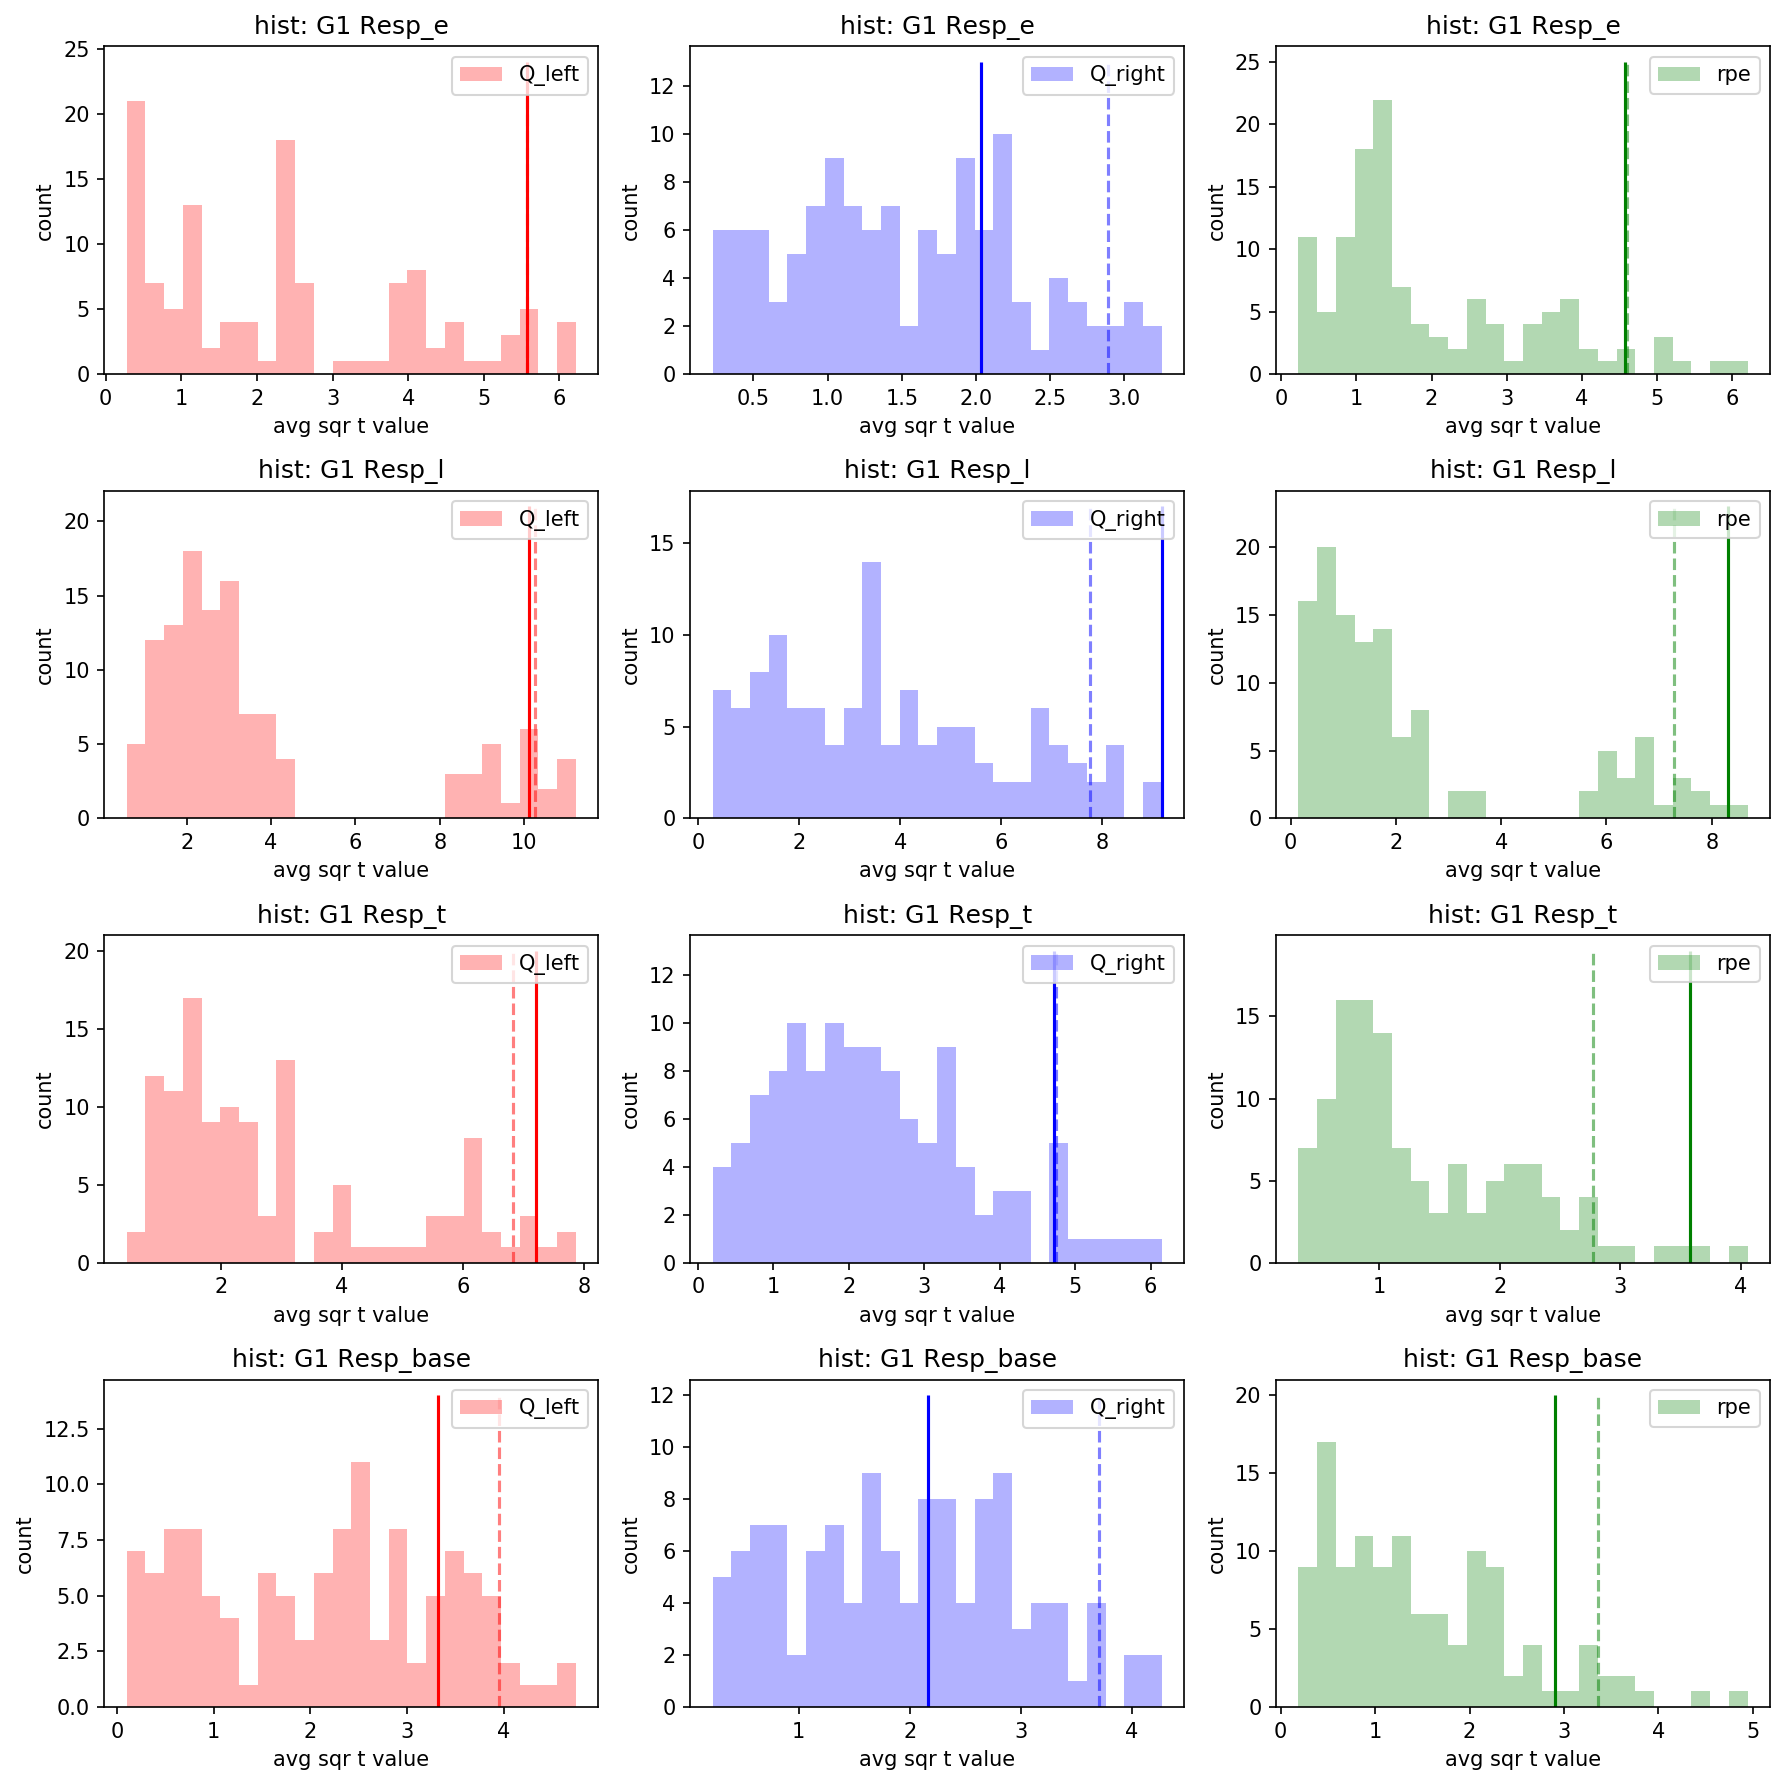

R1


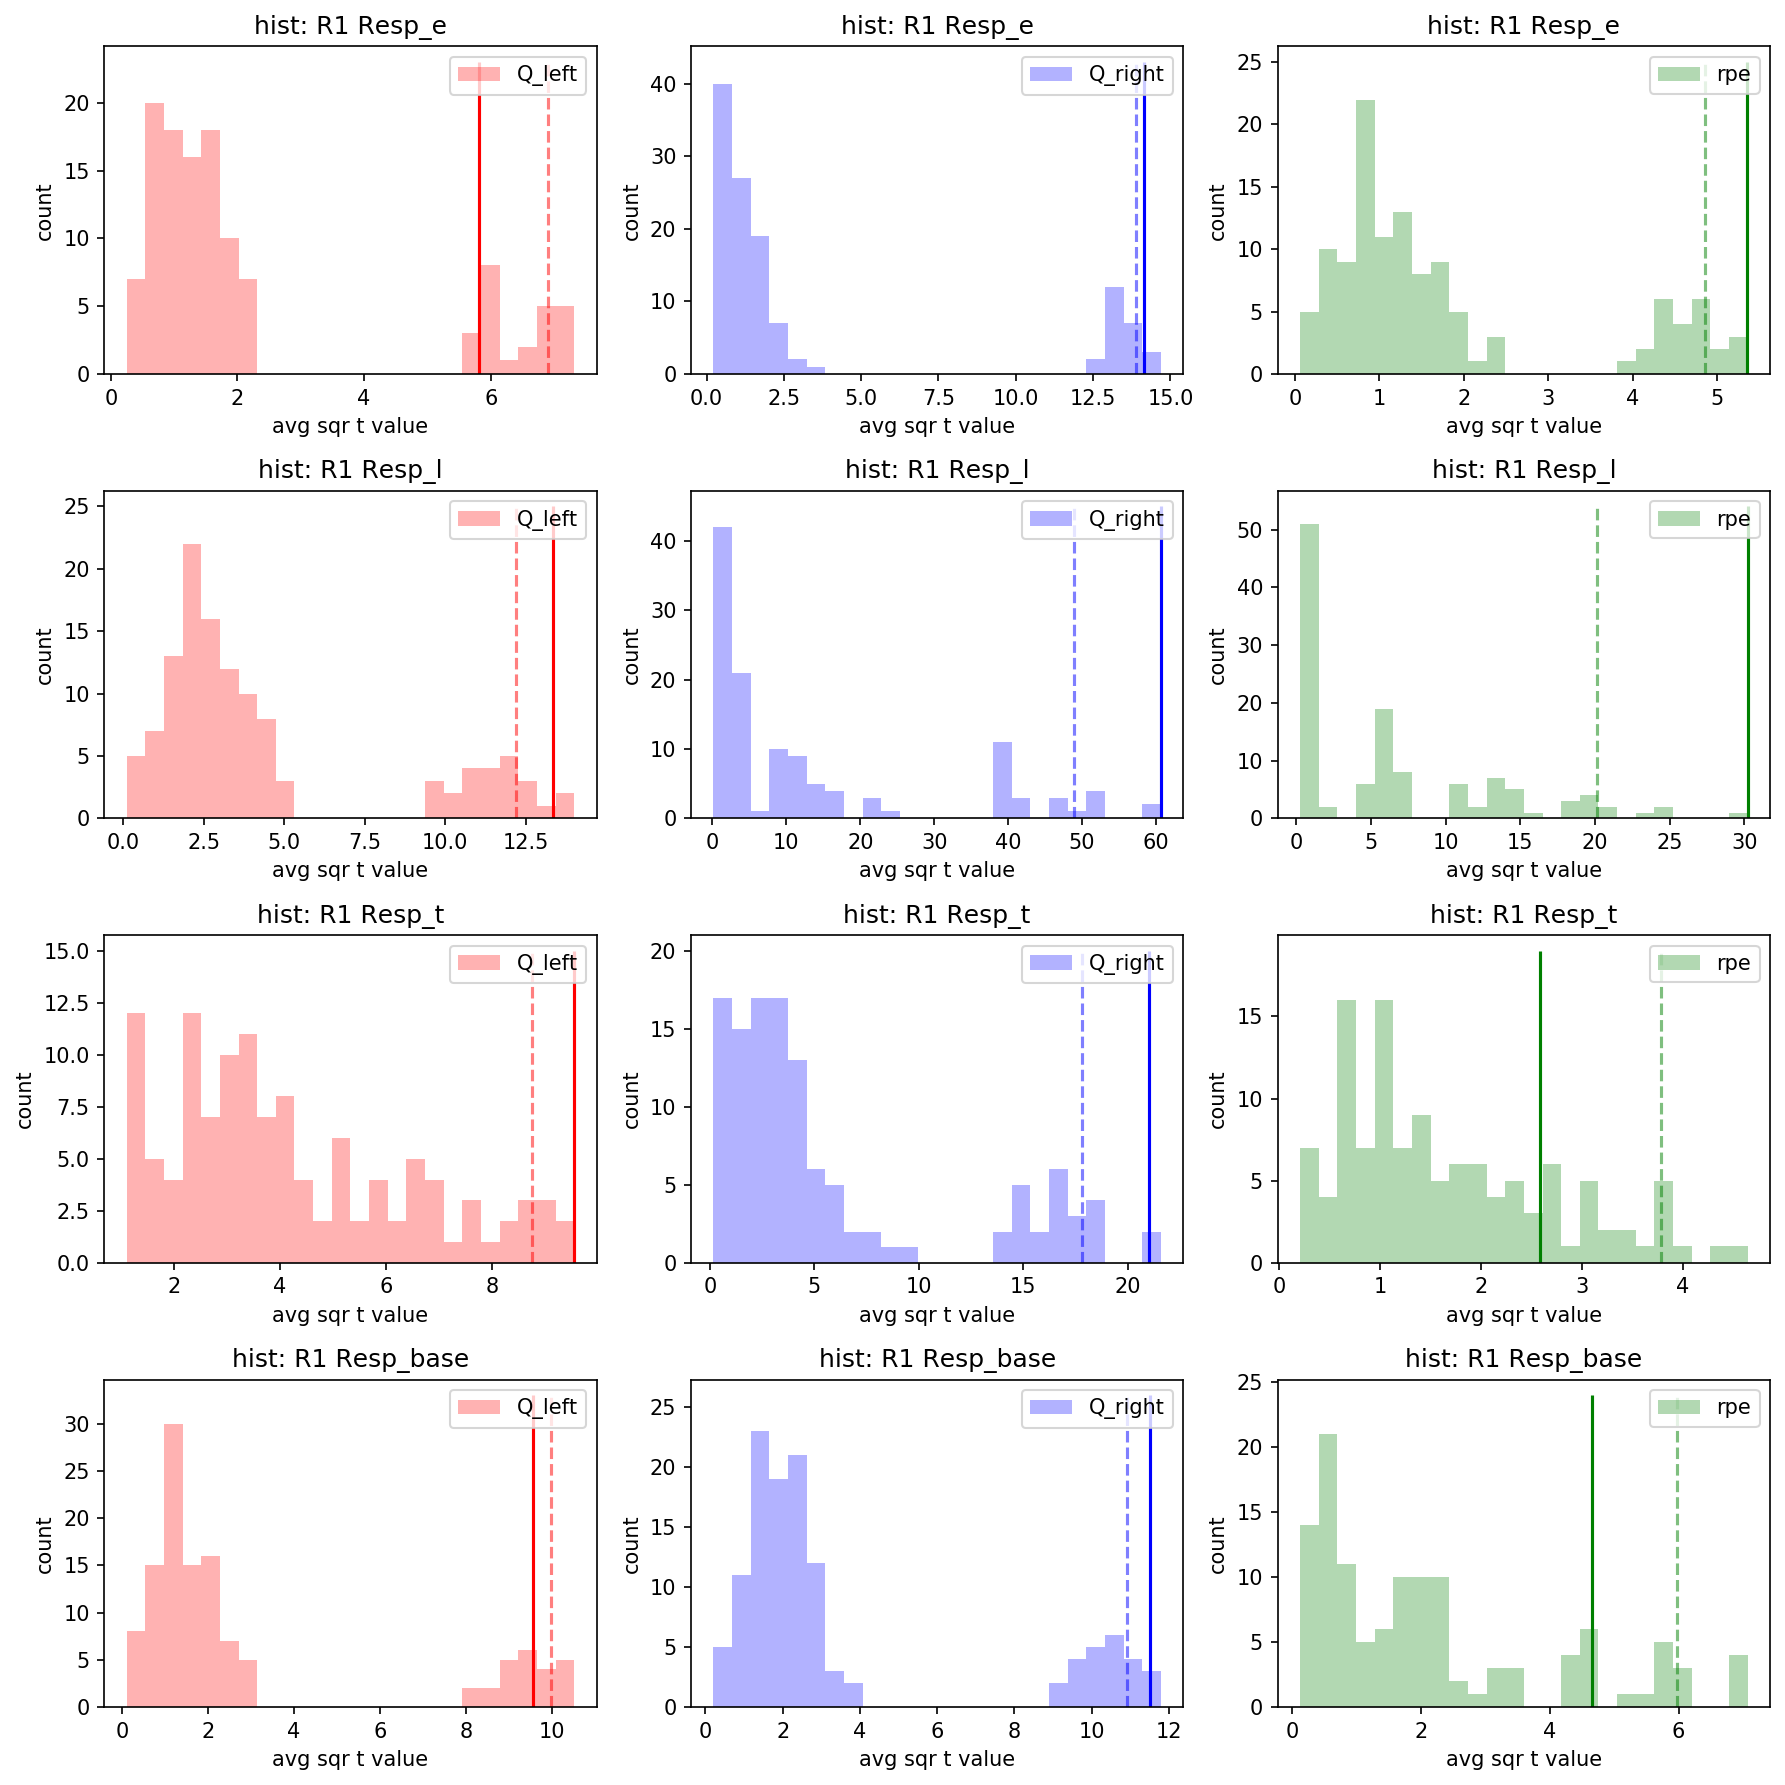

G2


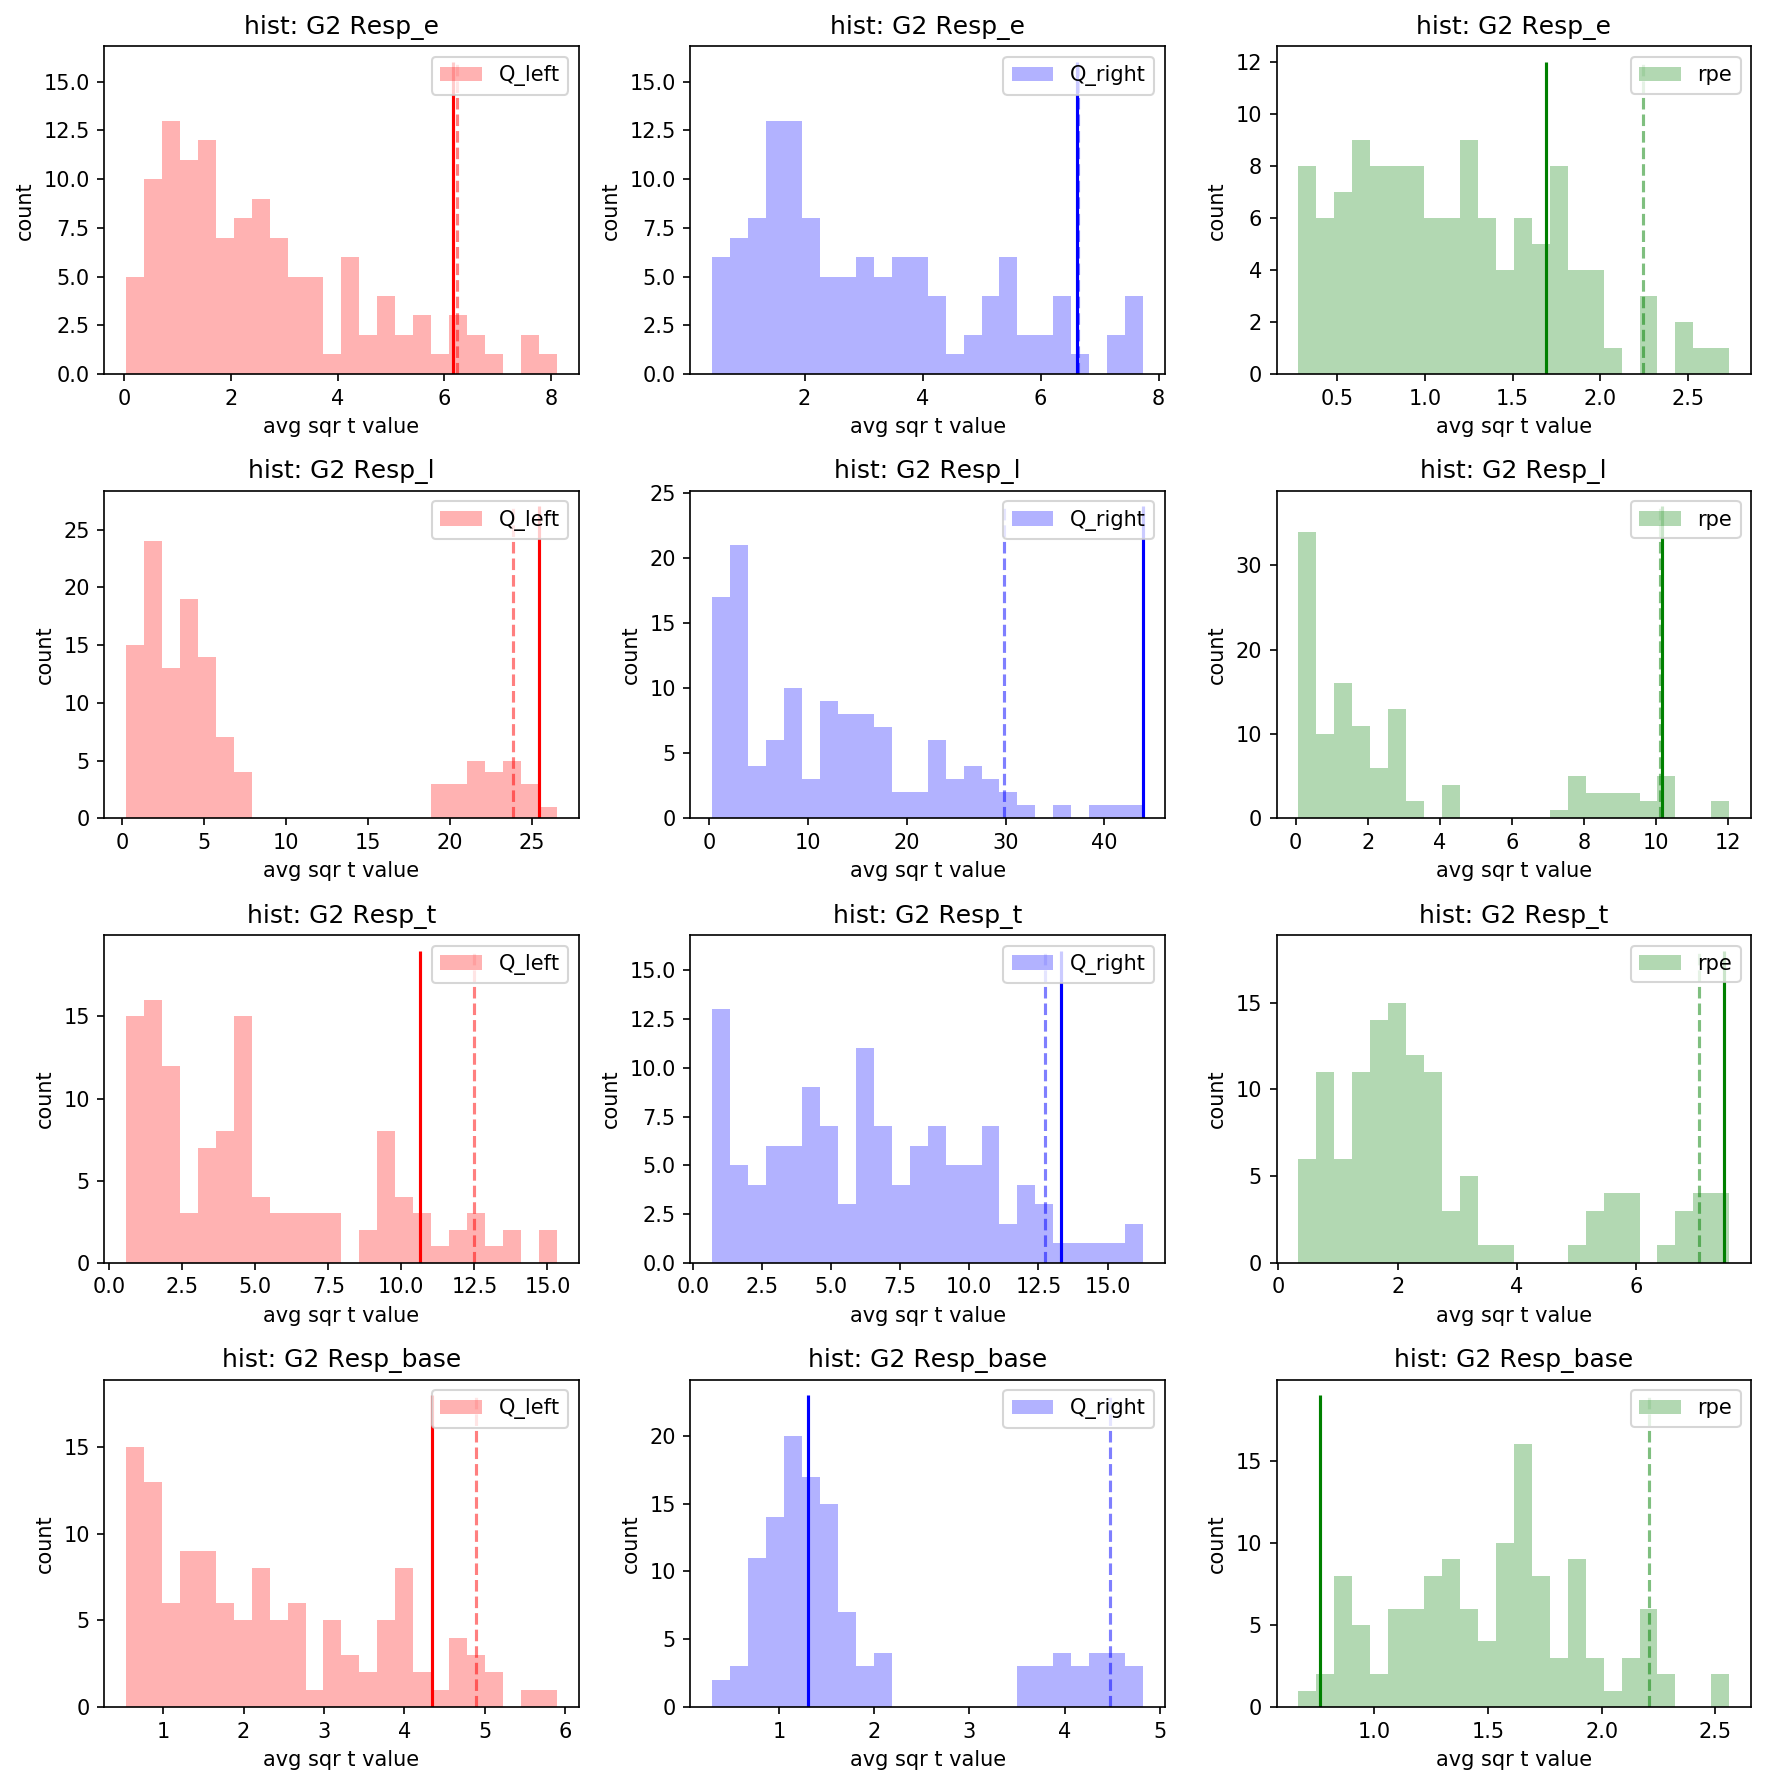

R2


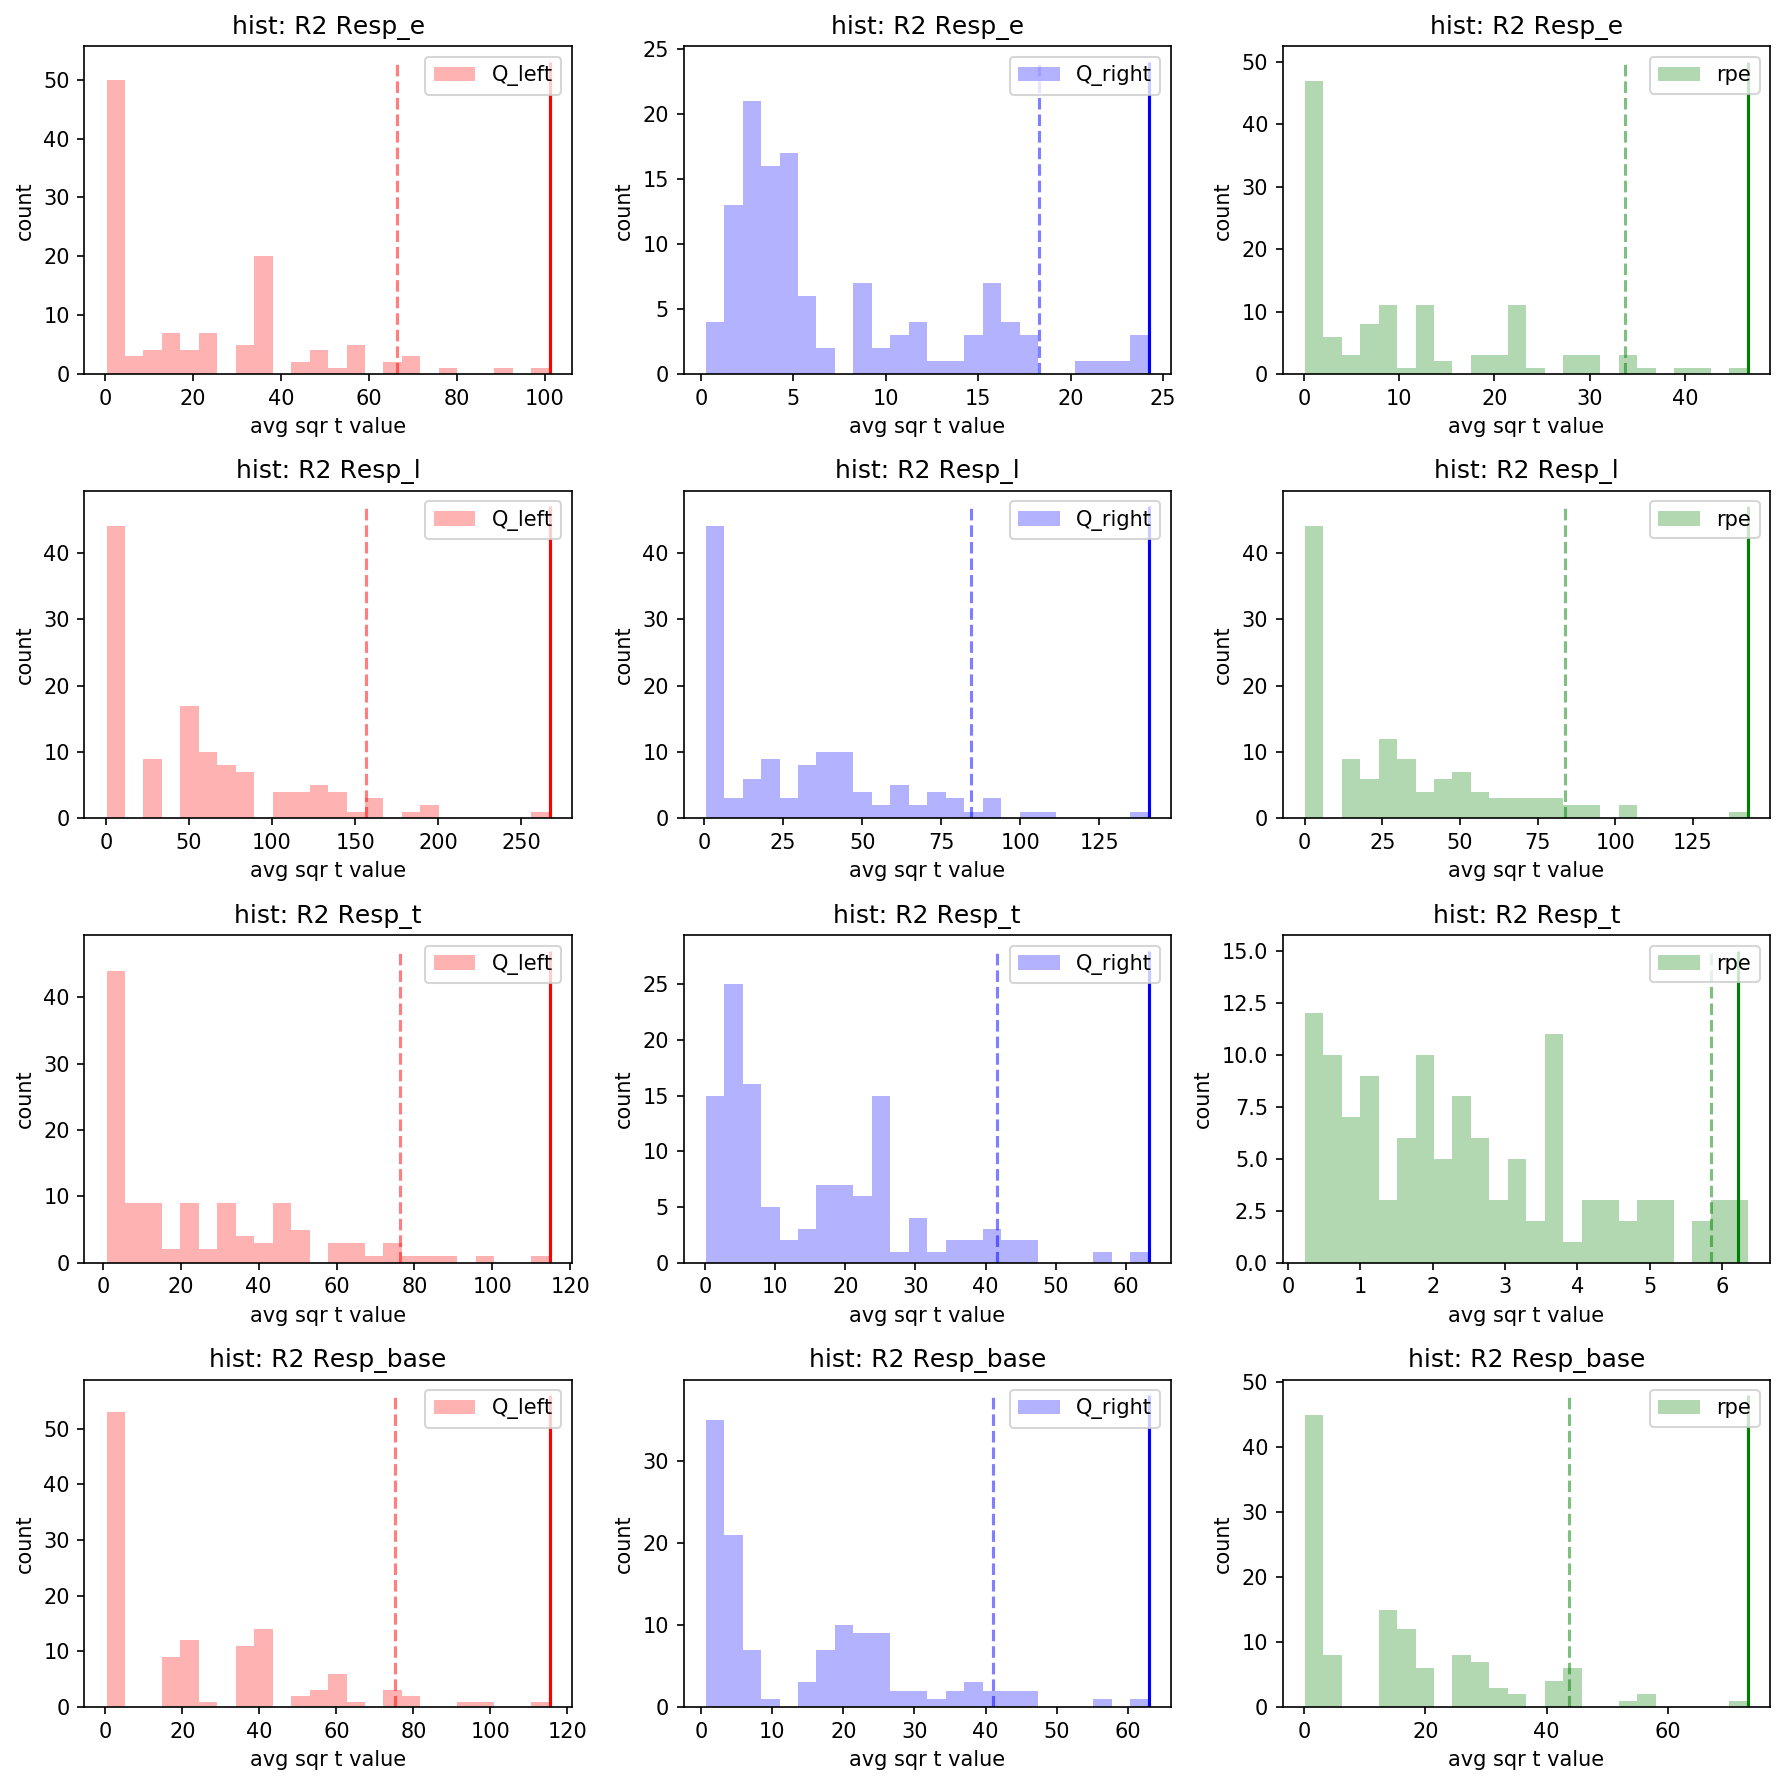

In [36]:
# plot msp fit, single neuron encoding

#with open('./ophys_msp_encode.pickle', 'rb') as handle:
#    df_msp_encode_dict = pickle.load(handle)


signal_types_to_fit = ['G1', 'R1', 'G2', 'R2']
resp_types = ['Resp_e', 'Resp_l', 'Resp_t', 'Resp_base']
q_types = ['Q_left', 'Q_right', 'rpe']

percentiles_2_compute = [2.5, 97.5]


# hist of ps ensemble
tvalue_lim = (-6, 6)
tvalue_sig_thresh = (-2, 2)
# Q_left/right scatter plot
tvalue_percentile_lim = (-5, 105)
dot_size = 10
# hist plot
colors = {
    'Q_left': 'r',
    'Q_right': 'b',
    'sigma_Q': 'c',
    'delta_Q': 'peru',
    'rpe': 'g'
}
# bar plot
classified_types = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q', 'rpe']
bar_colors = ['r', 'b', 'c', 'peru', 'g']


# plot
for signal_type_id, signal_type in enumerate(signal_types_to_fit):
    print(f'{signal_type}')
    df_fit = df_msp_encode_dict[signal_type]

    fig, axs = plt.subplots(
                    len(resp_types), 
                    3, # (hist of tvalues_Q_left, hist of tvalues_Q_right, hist of rpe) 
                    figsize=(4*3, 
                             3*len(resp_types)), 
                    dpi=150)
    
    for resp_type_id, resp_type in enumerate(resp_types):
        
        row_ind = resp_type_id
        df_fit_resp_type = df_fit[df_fit['resp_type']==resp_type]

        # calculate percentile of t values of self-fitted sessions
        # based on the ensemble of permutation of sessions

        df_fit_t_percentile_agnt_null = pd.DataFrame(columns=['resp_type', 
                                            'Q_left', 'Q_right', 'rpe'])

        if len(df_fit_resp_type) == 120:
            t_percentile_agnt_null = [resp_type]
            for i, q_type in enumerate(q_types):
                tvalues_q_type = np.vstack(df_fit_resp_type[f'tvalues_{q_type}'].values[:]).astype(np.float)
                avg_tvalues_q_type = np.average(np.square(tvalues_q_type), axis=1)
                # get self fitted t value
                df_self_fitted = df_fit_resp_type[df_fit_resp_type['gen_session_perm']==df_fit_resp_type['fit_session_perm']]
                if len(df_self_fitted) == 1:
                    tvalue_self_q_type = df_self_fitted.iloc[0][f'tvalues_{q_type}']
                    avg_tvalue_self_q_type = np.average(np.square(tvalue_self_q_type))
                else:
                    raise ValueError(f'incorrect self fitted df len: {len(df_self_fitted)}')

                t_percentile_agnt_null.append(stats.percentileofscore(avg_tvalues_q_type, 
                                                                      avg_tvalue_self_q_type))

                # histogram of regression tvalues
                col_ind = i
                avg_tvalues_percentile_q_type = np.percentile(avg_tvalues_q_type, 
                                                             [95]) #percentiles_2_compute)
                hist_q_type, _, _ = axs[row_ind, col_ind].hist(avg_tvalues_q_type, 
                                                               bins=24, histtype='stepfilled', 
                                                               color=colors[q_type], label=q_type, alpha=0.3)
                axs[row_ind, col_ind].vlines(avg_tvalue_self_q_type, 0, np.max(hist_q_type)+3, 
                                             color=colors[q_type])
                axs[row_ind, col_ind].vlines(avg_tvalues_percentile_q_type, 0, np.max(hist_q_type)+3, 
                                             color=colors[q_type], linestyle='--', alpha=0.5)
                axs[row_ind, col_ind].set_title(f'hist: {signal_type} {resp_type}')
                axs[row_ind, col_ind].set_xlabel('avg sqr t value')
                axs[row_ind, col_ind].set_ylabel('count')
                axs[row_ind, col_ind].legend()

            df_fit_t_percentile_agnt_null.loc[len(df_fit_t_percentile_agnt_null.index)] = t_percentile_agnt_null
            
        else:
            raise ValueError(f'wrong ps ensemble number: {len(df_fit_resp_type_session)}')

        '''
        print(f' df_fit_percentile_against_null: {df_fit_t_percentile_agnt_null.shape}')
        print(f' df_fit_percentile_against_null: {df_fit_t_percentile_agnt_null}')
        # Q_left/ right scatter
        col_ind = 1
        # choose tvalue_sig_threshold
        # (-2, 2) for naive case
        # tvalue_sig_threshold = {'Q_left': tvalue_sig_thresh, 
         #                       'Q_right': tvalue_sig_thresh} 
        # dynamic for adv analysis
        # tvalue_sig_threshold = {'Q_left': tvalues_percentile['Q_left'], 'Q_right': tvalues_percentile['Q_right']} 
        # (2.5, 97.5) for percentile case
        tvalue_sig_threshold = {'Q_left': percentiles_2_compute,
                                'Q_right': percentiles_2_compute} 
        df_fit_Q_left_sig = df_fit_t_percentile_agnt_null[
                                ((df_fit_t_percentile_agnt_null['Q_left']>=tvalue_sig_threshold['Q_left'][1]) | 
                                 (df_fit_t_percentile_agnt_null['Q_left']<=tvalue_sig_threshold['Q_left'][0])) & 
                                (df_fit_t_percentile_agnt_null['Q_right']<tvalue_sig_threshold['Q_right'][1]) & 
                                (df_fit_t_percentile_agnt_null['Q_right']>tvalue_sig_threshold['Q_right'][0])]
        axs[row_ind, col_ind].scatter(
                                df_fit_Q_left_sig['Q_left'].values, 
                                df_fit_Q_left_sig['Q_right'].values, 
                                color='r', s=dot_size, label='Q_left')
        df_fit_Q_right_sig = df_fit_t_percentile_agnt_null[
                                ((df_fit_t_percentile_agnt_null['Q_right']>=tvalue_sig_threshold['Q_right'][1]) | 
                                 (df_fit_t_percentile_agnt_null['Q_right']<=tvalue_sig_threshold['Q_right'][0])) & 
                                (df_fit_t_percentile_agnt_null['Q_left']<tvalue_sig_threshold['Q_left'][1]) & 
                                (df_fit_t_percentile_agnt_null['Q_left']>tvalue_sig_threshold['Q_left'][0])]
        axs[row_ind, col_ind].scatter(
                                df_fit_Q_right_sig['Q_left'].values, 
                                df_fit_Q_right_sig['Q_right'].values, 
                                color='b', s=dot_size, label='Q_right')
        df_fit_sigma_Q_sig = df_fit_t_percentile_agnt_null[
                                ((df_fit_t_percentile_agnt_null['Q_left']>=tvalue_sig_threshold['Q_left'][1]) & 
                                 (df_fit_t_percentile_agnt_null['Q_right']>=tvalue_sig_threshold['Q_right'][1])) | 
                                ((df_fit_t_percentile_agnt_null['Q_left']<=tvalue_sig_threshold['Q_left'][0]) & 
                                 (df_fit_t_percentile_agnt_null['Q_right']<=tvalue_sig_threshold['Q_right'][0]))]
        axs[row_ind, col_ind].scatter(
                                df_fit_sigma_Q_sig['Q_left'].values, 
                                df_fit_sigma_Q_sig['Q_right'].values, 
                                color='c', s=dot_size, label='sigma_Q')
        df_fit_delta_Q_sig = df_fit_t_percentile_agnt_null[
                                ((df_fit_t_percentile_agnt_null['Q_left']>=tvalue_sig_threshold['Q_left'][1]) & 
                                 (df_fit_t_percentile_agnt_null['Q_right']<=tvalue_sig_threshold['Q_right'][0])) | 
                                ((df_fit_t_percentile_agnt_null['Q_left']<=tvalue_sig_threshold['Q_left'][0]) & 
                                 (df_fit_t_percentile_agnt_null['Q_right']>=tvalue_sig_threshold['Q_right'][1]))]
        axs[row_ind, col_ind].scatter(
                                df_fit_delta_Q_sig['Q_left'].values, 
                                df_fit_delta_Q_sig['Q_right'].values, 
                                color='peru', s=dot_size, label='delta_Q')
        df_fit_null = df_fit_t_percentile_agnt_null[
                            (df_fit_t_percentile_agnt_null['Q_left']<tvalue_sig_threshold['Q_left'][1]) & 
                            (df_fit_t_percentile_agnt_null['Q_left']>tvalue_sig_threshold['Q_left'][0]) & 
                            (df_fit_t_percentile_agnt_null['Q_right']<tvalue_sig_threshold['Q_right'][1]) & 
                            (df_fit_t_percentile_agnt_null['Q_right']>tvalue_sig_threshold['Q_right'][0])]
        axs[row_ind, col_ind].scatter(
                                df_fit_null['Q_left'].values, 
                                df_fit_null['Q_right'].values, 
                                color='k', s=dot_size)
        sum_classified_sessions = len(df_fit_Q_left_sig)+len(df_fit_Q_right_sig)+ \
                                    len(df_fit_sigma_Q_sig)+len(df_fit_delta_Q_sig)+ \
                                    len(df_fit_null)
        if len(df_fit_t_percentile_agnt_null) != sum_classified_sessions:
            raise ValueError(f'sum of dots doesnt match: {len(df_fit_t_percentile_agnt_null)} {sum_classified_sessions}')

        axs[row_ind, col_ind].hlines(tvalue_sig_threshold['Q_right'], tvalue_percentile_lim[0], tvalue_percentile_lim[1], color='k', linestyle='--')
        axs[row_ind, col_ind].vlines(tvalue_sig_threshold['Q_left'], tvalue_percentile_lim[0], tvalue_percentile_lim[1], color='k', linestyle='--')
        axs[row_ind, col_ind].set_title(f'Q encoding analysis: {signal_type} {resp_type}')
        axs[row_ind, col_ind].set_xlim(tvalue_percentile_lim[0], tvalue_percentile_lim[1])
        axs[row_ind, col_ind].set_ylim(tvalue_percentile_lim[0], tvalue_percentile_lim[1])
        axs[row_ind, col_ind].set_xlabel('percentile of t values for Q_left')
        axs[row_ind, col_ind].set_ylabel('percentile of t values for Q_right')
        # axs[row_ind, col_ind].legend()


        # histogram of rpe tvalues
        col_ind = 2
            
        rpe_t_percentiles = df_fit_t_percentile_agnt_null['rpe'].values
        hist_q, _, _ = axs[row_ind, col_ind].hist(rpe_t_percentiles, 
                                                  bins=25, range=tvalue_percentile_lim, histtype='stepfilled', 
                                                  color=colors['rpe'], label='rpe', alpha=0.5)
        axs[row_ind, col_ind].vlines((2.5, 97.5), 0, np.max(hist_q)+2, 
                                     color='k', linestyle='--', alpha=0.5)
        axs[row_ind, col_ind].set_title(f'Hist of rpe t percentile agnt null: {signal_type} {resp_type}')
        axs[row_ind, col_ind].set_xlabel('avg t value percentile')
        axs[row_ind, col_ind].set_ylabel('count')
        axs[row_ind, col_ind].legend()

        n_sessions_rpe_sig = np.sum(((rpe_t_percentiles < 2.5) |
                                     (rpe_t_percentiles > 97.5)))

    
        # bar plot for significant neurons
        col_ind = 3
        n_sessions_fit = len(df_fit_t_percentile_agnt_null)
        print(f'{signal_type} {resp_type} total dots: {n_sessions_fit}')
        print(f' classified Q_left: {len(df_fit_Q_left_sig)}')
        print(f' classified Q_right: {len(df_fit_Q_right_sig)}')
        print(f' classified sigma_Q: {len(df_fit_sigma_Q_sig)}')
        print(f' classified delta_Q: {len(df_fit_delta_Q_sig)}')
        print(f' classified rpe: {n_sessions_rpe_sig}')
        classified_ratios = [
            len(df_fit_Q_left_sig)/ float(n_sessions_fit),
            len(df_fit_Q_right_sig)/ float(n_sessions_fit),
            len(df_fit_sigma_Q_sig)/ float(n_sessions_fit),
            len(df_fit_delta_Q_sig)/ float(n_sessions_fit),
            n_sessions_rpe_sig/ float(n_sessions_fit)]
        axs[row_ind, col_ind].bar(classified_types, classified_ratios, color=bar_colors)
        x_lim = axs[row_ind, col_ind].get_xlim()
        axs[row_ind, col_ind].hlines(0.05, x_lim[0], x_lim[1], color='k', linestyle='--')
        axs[row_ind, col_ind].set_title(f'ratio of classification: {signal_type} {resp_type}')
        axs[row_ind, col_ind].set_ylim(0, 1.05)
        '''
    plt.tight_layout()
    plt.show()